## Montage du lecteur Google Drive

Cette cellule de code utilise la bibliothèque google.colab pour monter le lecteur Google Drive dans l'environnement Colab, exactement dans l'emplacement '/content/drive'. Cela permet d'accéder aux fichiers stockés sur Google Drive depuis l'environnement de notebook Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 %cd /content/drive/MyDrive/Colab\ Notebooks/TimeSeriesForecasting

/content/drive/MyDrive/Colab Notebooks/TimeSeriesForecasting


Importation de la dataset de Kaggle

In [ ]:
#! kaggle datasets download robikscube/hourly-energy-consumption

Installation de PySpark

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e37400da19882cc954a4f887ddc3992d5c9f6d7a2f55c67b52789aeb1b11e507
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import FloatType
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import time
import seaborn as sns
color_pal = sns.color_palette()

In [ ]:
# !mkdir /content/streaming_data
# !cp /content/PJMW_hourly_streaming.csv /content/streaming_data/

mkdir: cannot create directory ‘/content/streaming_data’: File exists


## Chargement des données
Cette cellule de code ci-dessus charge un fichier CSV contenant des données de demande d'électricité par heure dans un DataFrame Pandas. La colonne 'Datetime' est convertie en objet datetime pour une analyse basée sur le temps.

In [ ]:
# Load the Data
file_path = 'PJMW_hourly_model.csv'  # Replace with your file path
data = pd.read_csv(file_path)
data['Datetime'] = pd.to_datetime(data['Datetime'])

### Ingénierie des fonctionnalités
Dans cette cellule, de nouvelles fonctionnalités telles que 'heure', 'jour de la semaine' et 'jour de l'année' sont extraites de la colonne 'Datetime', améliorant ainsi le jeu de données pour une meilleure performance du modèle.

In [ ]:
# Feature Engineering
data['hour'] = data['Datetime'].dt.hour
data['dayofweek'] = data['Datetime'].dt.dayofweek
data['dayofyear'] = data['Datetime'].dt.dayofyear

## Préparation des données
Le code prépare les données pour la modélisation, en créant des caractéristiques d'entrée (X) et la variable cible (y). Le jeu de données est divisé en ensembles d'entraînement et de test à l'aide de la fonction train_test_split.

In [ ]:
# Prepare Data for Model
X = data[['hour', 'dayofweek', 'dayofyear']]  # More features can be added as necessary
y = data['PJMW_MW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entraînement du modèle
Cette cellule utilise XGBoostRegressor pour entraîner un modèle d'apprentissage automatique sur les données préparées. Le modèle est configuré avec une erreur quadratique comme objectif et l'erreur quadratique moyenne (RMSE) comme métrique d'évaluation. La progression de l'entraînement est affichée avec une sortie détaillée.

In [ ]:
# Model Training
model = XGBRegressor(objective ='reg:squarederror', eval_metric="rmse")
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-rmse:785.71344	validation_1-rmse:795.04718
[10]	validation_0-rmse:493.91458	validation_1-rmse:499.46234
[20]	validation_0-rmse:473.58401	validation_1-rmse:481.37110
[30]	validation_0-rmse:465.58485	validation_1-rmse:475.02555
[40]	validation_0-rmse:456.87208	validation_1-rmse:467.85230
[50]	validation_0-rmse:450.73999	validation_1-rmse:463.27593
[60]	validation_0-rmse:445.89673	validation_1-rmse:460.59811
[70]	validation_0-rmse:440.48313	validation_1-rmse:456.92319
[80]	validation_0-rmse:436.31777	validation_1-rmse:453.97980
[90]	validation_0-rmse:432.37574	validation_1-rmse:451.19268
[99]	validation_0-rmse:428.91744	validation_1-rmse:449.14015


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Prédiction et Évaluation
Le modèle entraîné est utilisé pour prédire la variable cible sur l'ensemble de test, et l'erreur quadratique moyenne (MSE) est calculée et imprimée comme mesure de la performance du modèle.

In [ ]:
# Prediction and Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 201726.87004639852


## Traçage de la perte d'entraînement et de validation
Ici, les valeurs d'erreur quadratique moyenne (RMSE) d'entraînement et de validation sont tracées sur les époques pour visualiser la performance du modèle pendant l'entraînement.

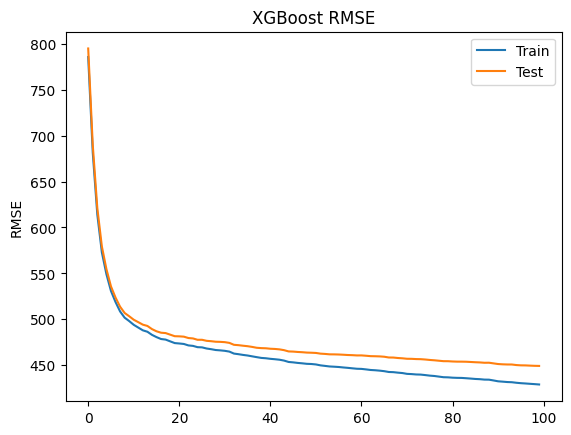

In [ ]:
# Plotting the training and validation loss
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

## Traitement et visualisation des données en continu
Cette cellule complexe ci-dessous intègre Spark Streaming avec le modèle XGBoost pré-entraîné pour des prédictions en temps réel de la demande d'électricité. Elle charge un modèle, configure une session Spark, définit un DataFrame en continu, génère des fonctionnalités, utilise une UDF Pandas pour faire des prédictions. Les prédictions sont ensuite affichées en temps réel, et le processus de streaming est visuellement représenté à travers un graphique dynamique. Le processus est orchestré à l'aide de requêtes Spark, et deux instances de données en continu avec prédictions sont affichées et tracées à intervalles. Enfin, la requête en continu est arrêtée.


+--------+-------+----+---------+---------+----------+
|Datetime|PJMW_MW|hour|dayofweek|dayofyear|prediction|
+--------+-------+----+---------+---------+----------+
+--------+-------+----+---------+---------+----------+



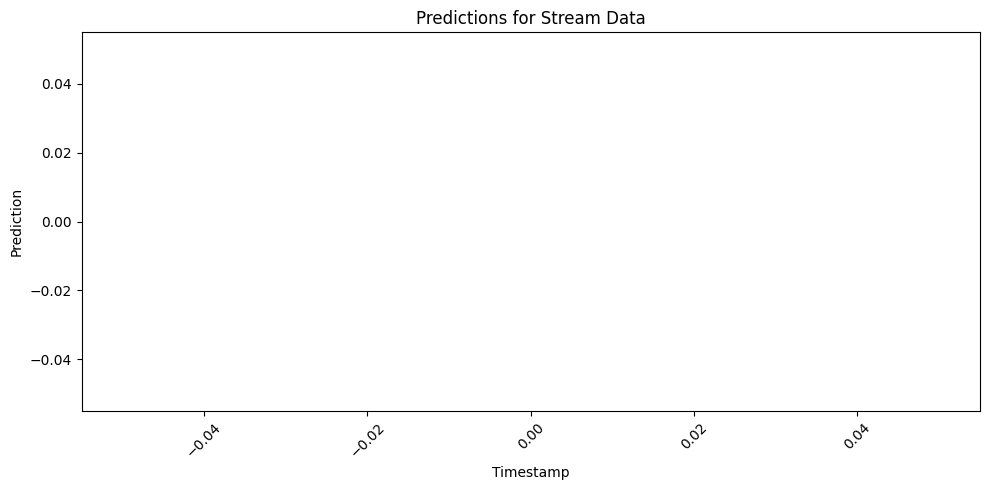

In [ ]:
# Stop any existing streaming query with the same name
for stream in spark.streams.active:
    if stream.name == "streaming_data":
        stream.stop()

# Function to load the XGBoost model
def load_model(model_path):
    return joblib.load(model_path)

# Load the trained XGBoost model
model = load_model('xgboost_model.pkl')

# Initialize SparkSession
spark = SparkSession.builder.appName("PowerDemandForecasting").master("local").getOrCreate()

# Define the directory containing the streaming data
streaming_directory = "streaming_data"

# The schema is inferred from the static DataFrame
static_df = spark.read.csv('streaming_data/PJMW_hourly_streaming.csv', header=True, inferSchema=True)
schema = static_df.schema

# Create a streaming DataFrame
streaming_df = spark.readStream.schema(schema).option("maxFilesPerTrigger", 1).csv(streaming_directory)

# Feature Engineering for streaming data
streaming_df = streaming_df.withColumn('hour', F.hour('Datetime'))
streaming_df = streaming_df.withColumn('dayofweek', F.dayofweek('Datetime'))
streaming_df = streaming_df.withColumn('dayofyear', F.dayofyear('Datetime'))

# Define a pandas UDF for making predictions
@pandas_udf(FloatType())
def predict_udf(hour: pd.Series, dayofweek: pd.Series, dayofyear: pd.Series) -> pd.Series:
    X = pd.DataFrame({'hour': hour, 'dayofweek': dayofweek, 'dayofyear': dayofyear})
    return pd.Series(model.predict(X))

# Apply the UDF to the streaming DataFrame for predictions
streaming_df_with_predictions = streaming_df.withColumn('prediction', predict_udf(F.col('hour'), F.col('dayofweek'), F.col('dayofyear')))

# Define a query to write the stream to an in-memory table
query = streaming_df_with_predictions.writeStream.format("memory").queryName("streaming_data").outputMode("append").start()

# Function to display streaming data with predictions
def display_next_stream_data_with_predictions(query_name, duration_seconds, interval_seconds):
    last_timestamp = spark.sql(f"SELECT MAX(Datetime) as last_timestamp FROM {query_name}").collect()[0]['last_timestamp']
    if last_timestamp is None:
        last_timestamp = '1970-01-01 00:00:00'

    end_time = time.time() + duration_seconds
    while time.time() < end_time:
        from IPython.display import clear_output
        clear_output(wait=True)

        new_last_timestamp = spark.sql(f"SELECT Datetime FROM {query_name} WHERE Datetime > '{last_timestamp}' ORDER BY Datetime LIMIT 5").agg(F.max("Datetime").alias("last_timestamp")).collect()[0]['last_timestamp']
        if new_last_timestamp is not None:
            last_timestamp = new_last_timestamp

        # Fetch streaming data
        stream_data = spark.sql(f"SELECT * FROM {query_name} WHERE Datetime > '{last_timestamp}' ORDER BY Datetime LIMIT 5")
        stream_data.show(truncate=False)

        # Extract predictions and timestamps
        timestamps = [row['Datetime'] for row in stream_data.collect()]
        predictions = [row['prediction'] for row in stream_data.collect()]

        # Plotting predictions for each stream
        plt.figure(figsize=(10, 5))
        plt.plot(timestamps, predictions, marker='o', linestyle='-', color='b')
        plt.xlabel('Timestamp')
        plt.ylabel('Prediction')
        plt.title('Predictions for Stream Data')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        time.sleep(interval_seconds)

# Display streaming data with predictions and plot
display_next_stream_data_with_predictions("streaming_data", 120, 5)

# Display streaming data with predictions
display_next_stream_data_with_predictions("streaming_data", 120, 5)

# Stop the streaming query
query.stop()